In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from util import *

# global

In [2]:
res_dir = "../../results/temporal/"

In [3]:
import matplotlib.colors as mcolors

# Convert hex to rgb
def hex_to_rgb(value):
    value = value.lstrip('#')
    return tuple(int(value[i:i+2], 16) for i in (0, 2, 4))

# Get complementary color
def get_complementary(color):
    r, g, b = hex_to_rgb(color)
    comp_color = ((255 - r) / 255.0, (255 - g) / 255.0, (255 - b) / 255.0)
    return mcolors.rgb2hex(comp_color)

# Define colors
primary_color_outcomes = '#6d9eeb'
complementary_color_outcomes = get_complementary(primary_color_outcomes)

primary_color_env = '#c27ba0'
complementary_color_env = get_complementary(primary_color_env)

# get data

In [4]:
dataset_2019 = pd.read_csv(data_folder+'{}_spatial_raw_master.csv'.format(2019), index_col='geography code').dropna()
dataset_2020 = pd.read_csv(data_folder+'{}_spatial_raw_master.csv'.format(2020), index_col='geography code').dropna()

# merge data

In [5]:
dataset_2019 = dataset_2019.rename(columns={c: f"{c}_2019" for c in dataset_2019.columns if (c.startswith("e") or c.startswith("o"))})
dataset_2020 = dataset_2020.rename(columns={c: f"{c}_2020" for c in dataset_2020.columns if (c.startswith("e") or c.startswith("o"))})

In [6]:
dataset_2020 = dataset_2020[[c for c in dataset_2020.columns if (c.startswith("e") or c.startswith("o")) ]]

In [7]:
data = dataset_2019.join(dataset_2020)

In [8]:
data.head()

,LSOA21NM,geometry,centroid_x,centroid_y,c_percent asian,c_percent black,c_percent mixed,c_percent white,c_percent christian,c_percent jewish,...,e_bare_2020,e_snow_and_ice_2020,o_diabetes_quantity_per_capita_2020,o_opioids_quantity_per_capita_2020,o_OME_per_capita_2020,o_total_quantity_per_capita_2020,o_asthma_quantity_per_capita_2020,o_hypertension_quantity_per_capita_2020,o_depression_quantity_per_capita_2020,o_anxiety_quantity_per_capita_2020
geography code,,,,,,,,,,,,,,,,,,,,,
E01000001,City of London 001A,"POLYGON ((532105.312 182010.573999999, 532162....",532151.194178,181615.201393,0.107191,0.007463,0.037992,0.801221,0.345763,0.019661,...,0.086469,0.092108,0.834958,0.129840,1.134302,13.827180,0.139674,1.047404,0.262661,0.195967
E01000002,City of London 001B,"POLYGON ((532634.497 181926.016000001, 532619....",532443.686041,181645.724884,0.130592,0.007937,0.043290,0.782107,0.338150,0.025289,...,0.094367,0.108474,0.957987,0.276066,2.587085,20.134107,0.203468,1.341916,0.378103,0.275255
E01000003,City of London 001C,"POLYGON ((532135.1382 182198.130999999, 532158...",532207.014825,182030.129598,0.094913,0.034739,0.062655,0.741315,0.340360,0.026658,...,0.070082,0.088695,1.532698,0.592661,5.072608,36.871135,0.361956,2.189897,0.738527,0.530043
E01000005,City of London 001E,"POLYGON ((533808.0176 180767.7744, 533649.037 ...",533618.348516,181157.354255,0.321526,0.108084,0.071753,0.385104,0.367514,0.012704,...,0.109265,0.072893,0.918772,0.250619,2.218236,24.657966,0.359229,1.447732,0.827553,0.481856
E01000006,Barking and Dagenham 016A,"POLYGON ((545122.049 184314.931, 545271.8494 1...",544934.369716,184297.546524,0.479675,0.108401,0.037940,0.327913,0.371614,0.000542,...,0.072455,0.032890,33.986967,4.982723,191.202486,545.239412,5.155322,36.456869,5.625583,4.351535


# plot outcomes

In [9]:
# Splitting columns by year
columns_2019 = [c for c in data.columns if '2019' in c and c.startswith("o") and not 'total' in c and not 'OME' in c]
columns_2020 = [c for c in data.columns if '2020' in c and c.startswith("o") and not 'total' in c and not 'OME' in c]

In [10]:
# Define the column sets for each year
columns_2019 = [
    'o_diabetes_quantity_per_capita_2019',
    'o_opioids_quantity_per_capita_2019',
    'o_asthma_quantity_per_capita_2019',
    'o_hypertension_quantity_per_capita_2019',
    'o_depression_quantity_per_capita_2019',
    'o_anxiety_quantity_per_capita_2019'
]

columns_2020 = [
    'o_diabetes_quantity_per_capita_2020',
    'o_opioids_quantity_per_capita_2020',
    'o_asthma_quantity_per_capita_2020',
    'o_hypertension_quantity_per_capita_2020',
    'o_depression_quantity_per_capita_2020',
    'o_anxiety_quantity_per_capita_2020'
]

# Perform the KS test for equivalent variables between years
for col_2019, col_2020 in zip(columns_2019, columns_2020):
    statistic, p_value = ks_2samp(data[col_2019], data[col_2020])
    print(f"Comparing {col_2019} and {col_2020}:")
    print(f"KS statistic: {statistic:.4f}, P-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"The distributions of {col_2019} and {col_2020} are significantly different.\n")
    else:
        print(f"The distributions of {col_2019} and {col_2020} are not significantly different.\n")

Comparing o_diabetes_quantity_per_capita_2019 and o_diabetes_quantity_per_capita_2020:
KS statistic: 0.0526, P-value: 0.0000
The distributions of o_diabetes_quantity_per_capita_2019 and o_diabetes_quantity_per_capita_2020 are significantly different.

Comparing o_opioids_quantity_per_capita_2019 and o_opioids_quantity_per_capita_2020:
KS statistic: 0.0076, P-value: 0.3753
The distributions of o_opioids_quantity_per_capita_2019 and o_opioids_quantity_per_capita_2020 are not significantly different.

Comparing o_asthma_quantity_per_capita_2019 and o_asthma_quantity_per_capita_2020:
KS statistic: 0.0483, P-value: 0.0000
The distributions of o_asthma_quantity_per_capita_2019 and o_asthma_quantity_per_capita_2020 are significantly different.

Comparing o_hypertension_quantity_per_capita_2019 and o_hypertension_quantity_per_capita_2020:
KS statistic: 0.0215, P-value: 0.0000
The distributions of o_hypertension_quantity_per_capita_2019 and o_hypertension_quantity_per_capita_2020 are significan

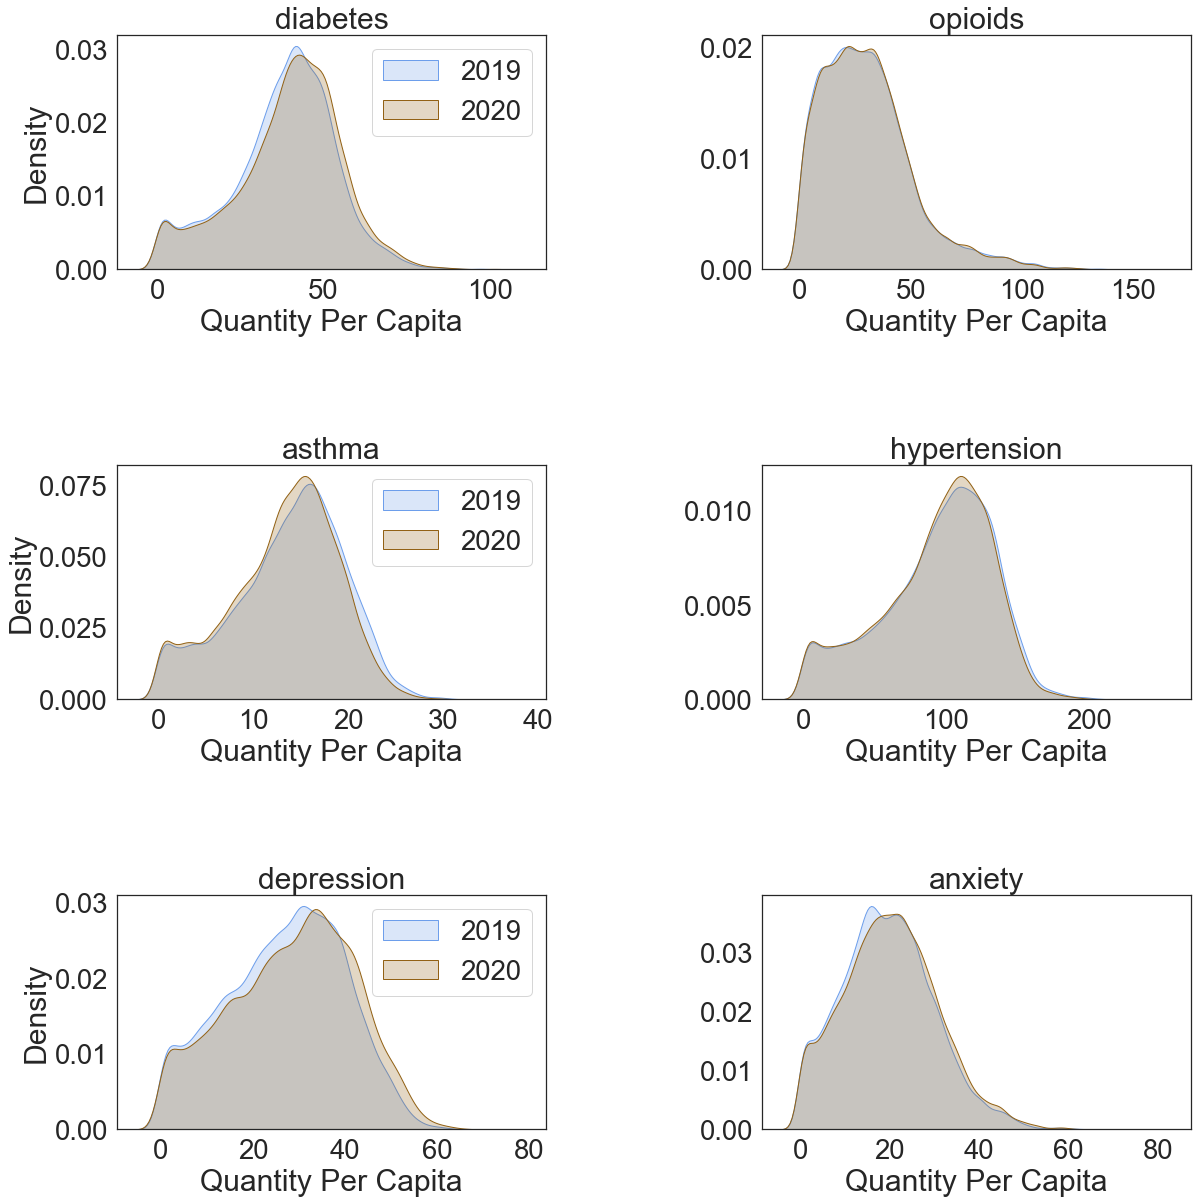

In [20]:
# Set style and larger font
sns.set(style="white", font_scale=2.5)

# Create subplots: 3 rows by 2 columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
fig.tight_layout(pad=5.0)  # Add padding for better layout

for i, (col_2019, col_2020) in enumerate(zip(columns_2019, columns_2020)):
    ax = axes[i//2, i%2]
    
    # Extract condition name and format it
    condition_name = col_2019.split('_')[1]
    outcome_name = ' '.join(col_2019.split('_')[1:-1])
    
    sns.kdeplot(data[col_2019], fill=True, color=primary_color_outcomes, label=f"2019", ax=ax)
    sns.kdeplot(data[col_2020], fill=True, color=complementary_color_outcomes, label=f"2020", ax=ax)
    
    ax.set_title(f"{condition_name}")
    ax.set_xlabel("Quantity Per Capita")
    ax.set_ylabel("Density")

    # Display the legend only for the first column of each row
    if i%2 == 0:
        ax.legend()
        ax.set_ylabel("Density")
    else:
        ax.legend().set_visible(False)
        ax.set_ylabel("")


plt.savefig(f"{res_dir}/outcomes_distributions.pdf", dpi=300)
plt.show()

# plot enviornmental

In [12]:

# Splitting columns by year
e_columns_2019 = [c for c in data.columns if '2019' in c and c.startswith("e") ]
e_columns_2020 = [c for c in data.columns if '2020' in c and c.startswith("e")]

In [13]:
e_columns_2020

['e_NO2_2020',
 'e_ozone_2020',
 'e_total_aerosol_optical_depth_at_550nm_surface_2020',
 'e_particulate_matter_d_less_than_25_um_surface_2020',
 'e_ndvi_2020',
 'e_dewpoint_temperature_2m_2020',
 'e_temperature_2m_2020',
 'e_soil_temperature_level_1_2020',
 'e_soil_temperature_level_3_2020',
 'e_lake_bottom_temperature_2020',
 'e_lake_mix_layer_depth_2020',
 'e_lake_mix_layer_temperature_2020',
 'e_lake_total_layer_temperature_2020',
 'e_snow_albedo_2020',
 'e_snow_cover_2020',
 'e_snow_density_2020',
 'e_snow_depth_2020',
 'e_skin_reservoir_content_2020',
 'e_volumetric_soil_water_layer_1_2020',
 'e_volumetric_soil_water_layer_3_2020',
 'e_surface_latent_heat_flux_sum_2020',
 'e_surface_net_solar_radiation_sum_2020',
 'e_surface_solar_radiation_downwards_sum_2020',
 'e_surface_thermal_radiation_downwards_sum_2020',
 'e_evaporation_from_bare_soil_sum_2020',
 'e_evaporation_from_the_top_of_canopy_sum_2020',
 'e_evaporation_from_open_water_surfaces_excluding_oceans_sum_2020',
 'e_total_e

In [14]:

# Define the column sets for each year
e_columns_2019 = ['e_NO2_2019',
 'e_ozone_2019',
 'e_total_aerosol_optical_depth_at_550nm_surface_2019',
 'e_particulate_matter_d_less_than_25_um_surface_2019',
 'e_ndvi_2019',
 'e_trees_2019',
 'e_leaf_area_index_low_vegetation_2019',
 'e_built_2019',
 'e_temperature_2m_2019',
 'e_surface_solar_radiation_downwards_sum_2019',
 'e_u_component_of_wind_10m_2019',
 'e_v_component_of_wind_10m_2019']

e_columns_2020 = [col.replace('_2019', '_2020') for col in e_columns_2019]

# columns_2020 = ['e_NO2_2020',
#  'e_ozone_2020',
#  'e_total_aerosol_optical_depth_at_550nm_surface_2020',
#  'e_particulate_matter_d_less_than_25_um_surface_2020',
#  'e_ndvi_2020',
#  'e_dewpoint_temperature_2m_2020',
#  'e_temperature_2m_2020',
#  'e_soil_temperature_level_1_2020',
#  'e_soil_temperature_level_3_2020',
#  'e_lake_bottom_temperature_2020',
#  'e_lake_mix_layer_depth_2020',
#  'e_lake_mix_layer_temperature_2020',
#  'e_lake_total_layer_temperature_2020',
#  'e_snow_albedo_2020',
#  'e_snow_cover_2020',
#  'e_snow_density_2020',
#  'e_snow_depth_2020',
#  'e_skin_reservoir_content_2020',
#  'e_volumetric_soil_water_layer_1_2020',
#  'e_volumetric_soil_water_layer_3_2020',
#  'e_surface_latent_heat_flux_sum_2020',
#  'e_surface_net_solar_radiation_sum_2020',
#  'e_surface_solar_radiation_downwards_sum_2020',
#  'e_surface_thermal_radiation_downwards_sum_2020',
#  'e_evaporation_from_bare_soil_sum_2020',
#  'e_evaporation_from_the_top_of_canopy_sum_2020',
#  'e_evaporation_from_open_water_surfaces_excluding_oceans_sum_2020',
#  'e_total_evaporation_sum_2020',
#  'e_u_component_of_wind_10m_2020',
#  'e_v_component_of_wind_10m_2020',
#  'e_surface_pressure_2020',
#  'e_total_precipitation_sum_2020',
#  'e_leaf_area_index_high_vegetation_2020',
#  'e_leaf_area_index_low_vegetation_2020',
#  'e_surface_runoff_sum_2020',
#  'e_water_2020',
#  'e_trees_2020',
#  'e_grass_2020',
#  'e_flooded_vegetation_2020',
#  'e_crops_2020',
#  'e_shrub_and_scrub_2020',
#  'e_built_2020',
#  'e_bare_2020',
#  'e_snow_and_ice_2020']

# Perform the KS test for equivalent variables between years
for e_col_2019, e_col_2020 in zip(e_columns_2019, e_columns_2020):
    statistic, p_value = ks_2samp(data[e_col_2019], data[e_col_2020])
    print(f"Comparing {e_col_2019} and {e_col_2020}:")
    print(f"KS statistic: {statistic:.4f}, P-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"The distributions of {e_col_2019} and {e_col_2020} are significantly different.\n")
    else:
        print(f"The distributions of {e_col_2019} and {e_col_2020} are not significantly different.\n")



Comparing e_NO2_2019 and e_NO2_2020:
KS statistic: 0.4926, P-value: 0.0000
The distributions of e_NO2_2019 and e_NO2_2020 are significantly different.

Comparing e_ozone_2019 and e_ozone_2020:
KS statistic: 0.9992, P-value: 0.0000
The distributions of e_ozone_2019 and e_ozone_2020 are significantly different.

Comparing e_total_aerosol_optical_depth_at_550nm_surface_2019 and e_total_aerosol_optical_depth_at_550nm_surface_2020:
KS statistic: 0.4745, P-value: 0.0000
The distributions of e_total_aerosol_optical_depth_at_550nm_surface_2019 and e_total_aerosol_optical_depth_at_550nm_surface_2020 are significantly different.

Comparing e_particulate_matter_d_less_than_25_um_surface_2019 and e_particulate_matter_d_less_than_25_um_surface_2020:
KS statistic: 0.5895, P-value: 0.0000
The distributions of e_particulate_matter_d_less_than_25_um_surface_2019 and e_particulate_matter_d_less_than_25_um_surface_2020 are significantly different.

Comparing e_ndvi_2019 and e_ndvi_2020:
KS statistic: 0.0

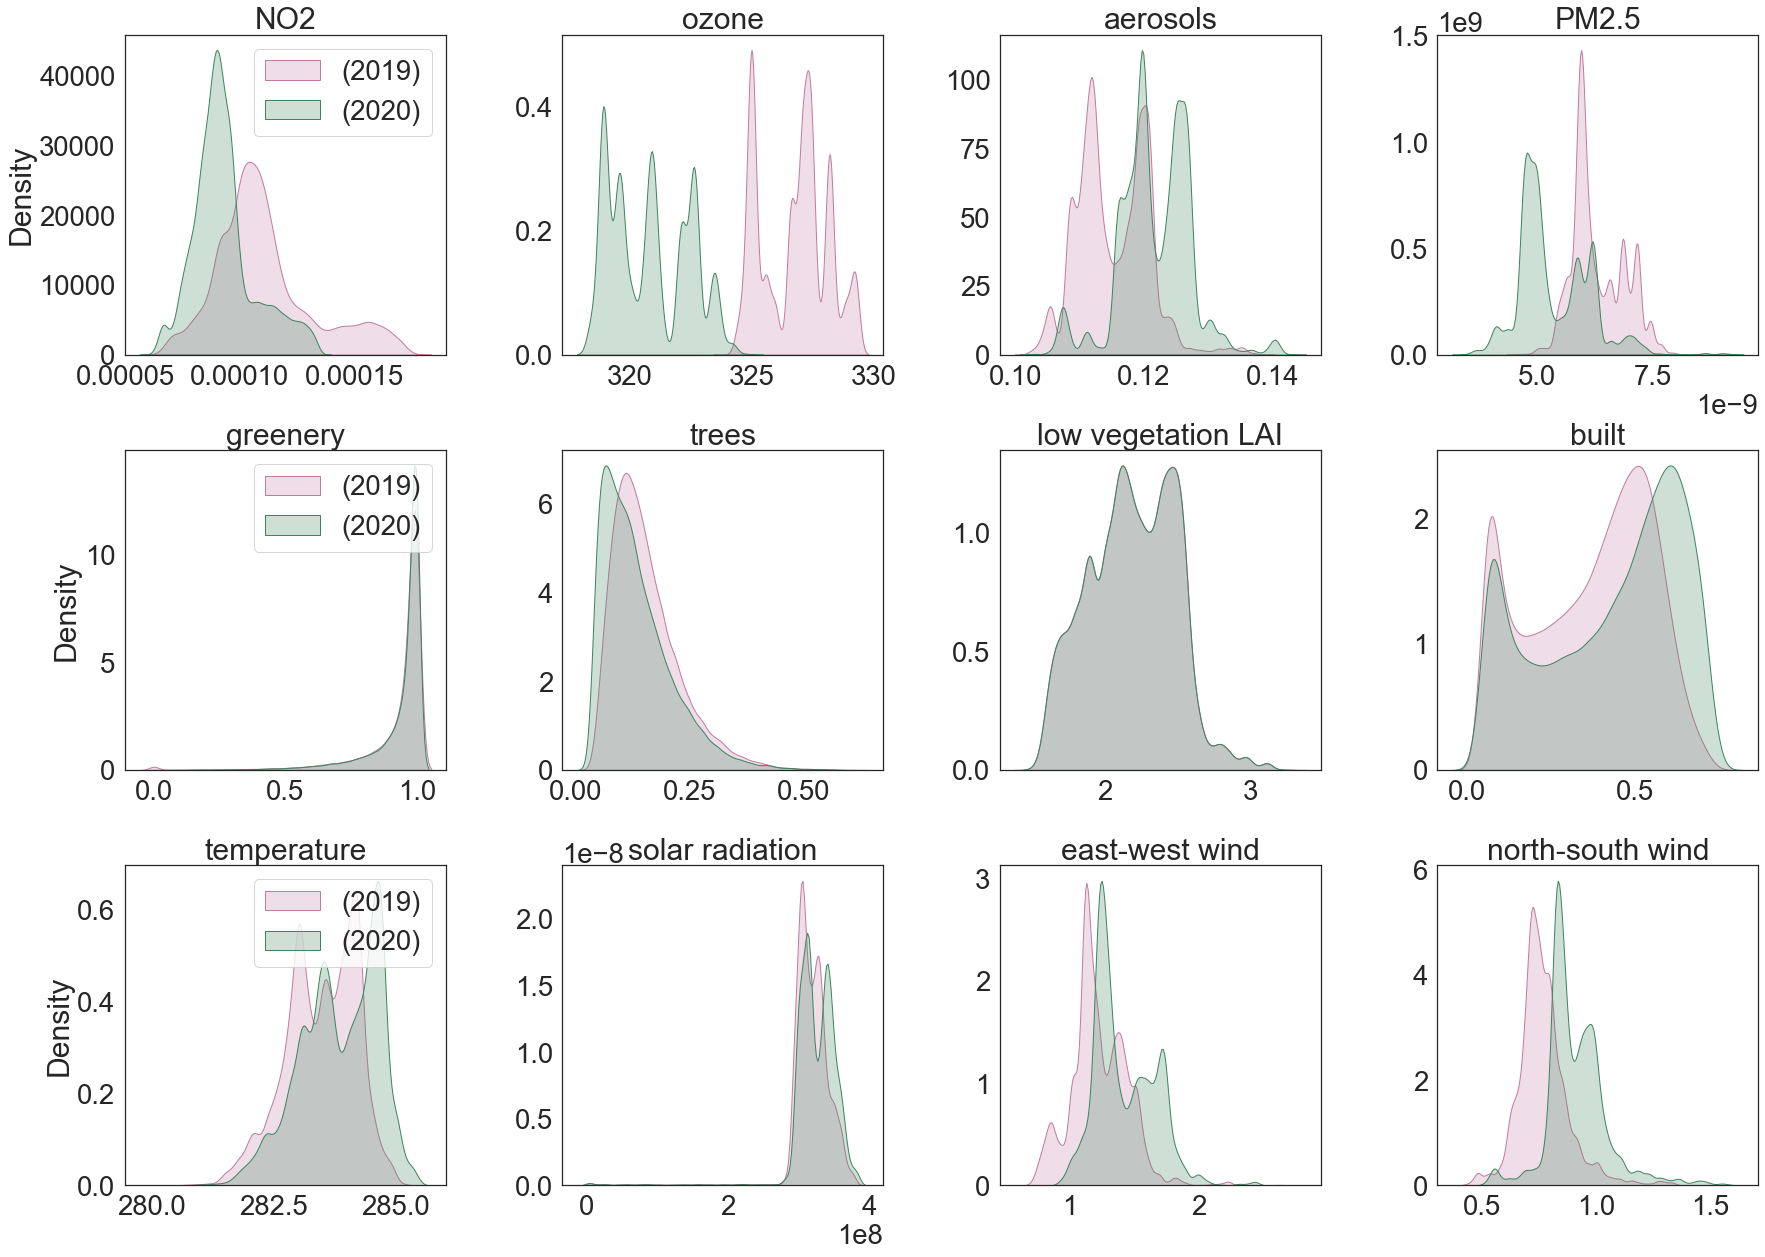

In [19]:
# Create subplots: 4 rows by 4 columns
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(25, 18))
fig.tight_layout(pad=5.0)  # Add padding for better layout

# You might have an empty plot because 15 doesn't fill 4x4 grid. Let's hide it.
# axes[2, 3].axis('off')

for i, (e_col_2019, e_col_2020) in enumerate(zip(e_columns_2019, e_columns_2020)):
    ax = axes[i//4, i%4]
    
    # Extract environment factor name and format it
    environment_factor_name = '_'.join(e_col_2019.split('_')[1:-1])
    environment_factor_name = variable_mapping["e_"+environment_factor_name]
    
    sns.kdeplot(data[e_col_2019], fill=True, color=primary_color_env, label=f"(2019)", ax=ax)
    sns.kdeplot(data[e_col_2020], fill=True, color=complementary_color_env, label=f"(2020)", ax=ax)
    
    ax.set_title(f"{environment_factor_name}")
    ax.set_xlabel("")
    # ax.legend()

    # Display the legend only for the first column of each row
    if i%4 == 0:
        ax.legend()
        ax.set_ylabel("Density")
    else:
        ax.legend().set_visible(False)
        ax.set_ylabel("")

plt.savefig(f"{res_dir}/env_distributions.pdf", dpi=300)
plt.show()